In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#tf input pipeline
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "resource",
    shuffle = True,
    image_size = (256,256),
    batch_size = 32
) 

Found 2152 files belonging to 3 classes.


In [3]:
classes = dataset.class_names
print(classes)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [4]:
print("total num of images:",len(dataset)*32)

total num of images: 2176


In [5]:
#for first class
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 2 1 1 0 1 0 1 1 1 2 0 0 1 0 0]


(256, 256, 3)


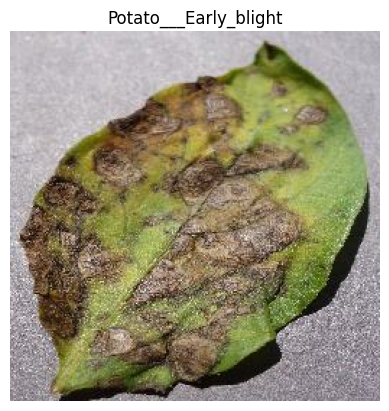

In [6]:
#visualizing images

for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[1].numpy().astype("uint8"))

    print(image_batch[1].shape)
    plt.axis("off")
    plt.title(classes[label_batch[1]])

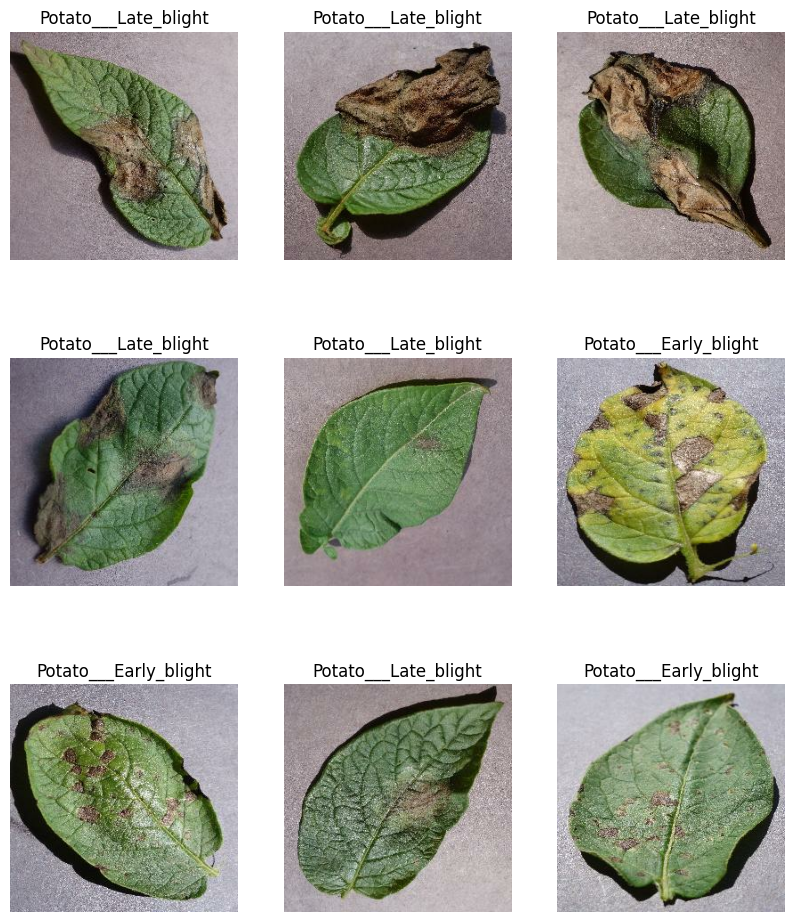

In [7]:
#more visualization
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10,12))
    for i in range(9):
        view = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        # print(image_batch[1].shape)
        plt.axis("off")
        plt.title(classes[label_batch[i]])

In [23]:
#splitting 80:20
#in 20% test --> 10% actual test, 10% validation split

channels =3 #RGB images
epochs =25

from sklearn.model_selection import train_test_split

training_size = 0.8
print("training set approx:",len(dataset)*training_size)

training set approx: 54.400000000000006


In [9]:
train = dataset.take(54)
test = dataset.skip(54)

In [10]:
validation = 0.1
print("validation size approx",len(dataset)*validation)

validation size approx 6.800000000000001


In [11]:
val = test.take(7)
len(val)

7

In [12]:
actual_test = test.skip(7)
len(actual_test)

7

In [13]:
#function for the same
def df_partition(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    size = len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*size)
    val_size=int(val_split*size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = df_partition(dataset)

In [15]:
print("Training set -->",len(train_ds))
print("Validation set -->",len(val_ds))
print("test set -->",len(test_ds))

Training set --> 54
Validation set --> 6
test set --> 8


In [16]:
#caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
#IMAGE SCALING
resize_rescale = tf.keras.Sequential([
    layers.Resizing(256 ,256),
    layers.Rescaling(1.0/255)
])

In [18]:
#data augmentation
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
#MODEL BUILDING
input_shape = (32,256,256,3)
model = models.Sequential([
    resize_rescale,
    augment,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 

    #Dense Network
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation = 'softmax'),
])

model.build(input_shape=input_shape)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(train_ds, 
          epochs = epochs, 
          verbose=1, 
          batch_size =32, 
          validation_data = val_ds
         )

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.4604 - loss: 0.9132 - val_accuracy: 0.5104 - val_loss: 0.8086
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6197 - loss: 0.7314 - val_accuracy: 0.7309 - val_loss: 0.5679
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7808 - loss: 0.4732 - val_accuracy: 0.8605 - val_loss: 0.3673
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8615 - loss: 0.3344 - val_accuracy: 0.8148 - val_loss: 0.4083
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8903 - loss: 0.2871 - val_accuracy: 0.9265 - val_loss: 0.2076
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8971 - loss: 0.2297 - val_accuracy: 0.8964 - val_loss: 0.2421
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9266 - loss: 0.1718 - val_accuracy: 0.9473 - val_loss: 0.1357
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9484 - loss: 0.1334 - val_accuracy: 0.8611 - val_loss:

In [26]:
scores = model.evaluate(test_ds)

print("Loss : ",scores[0])
print("Accuracy : ",scores[1])

54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 283ms/step - accuracy: 0.9616 - loss: 0.1246
Loss :  0.11417116969823837
Accuracy :  0.9646990895271301


In [27]:
#plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

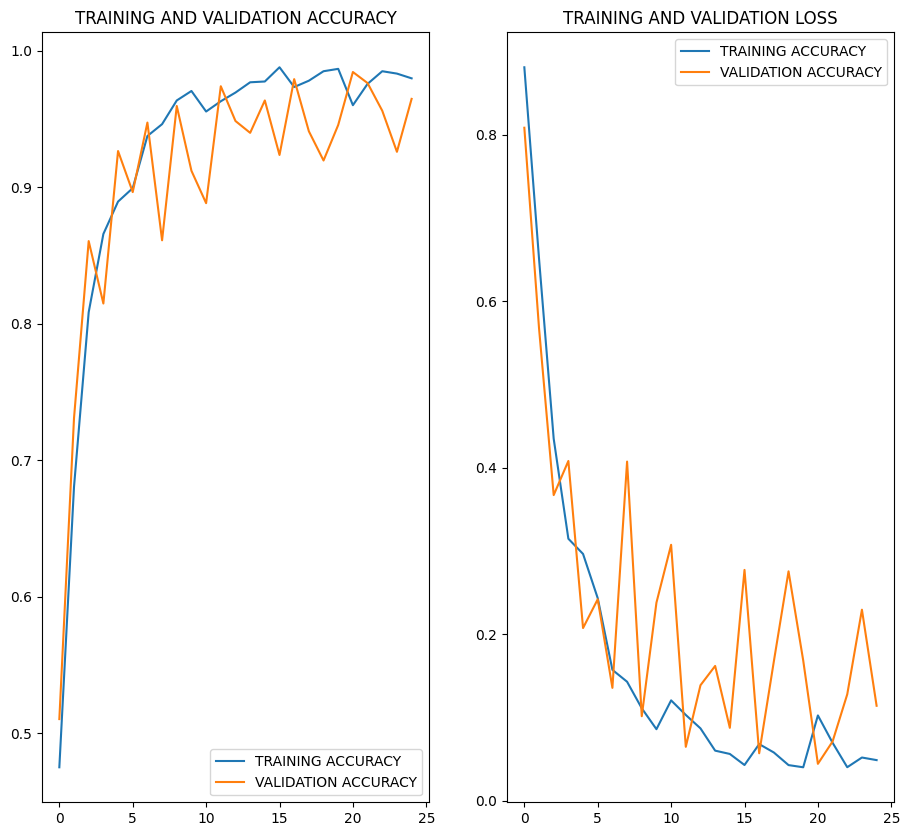

In [29]:
plt.figure(figsize = (11,10))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = "TRAINING ACCURACY")
plt.plot(range(epochs), val_acc, label = "VALIDATION ACCURACY")
plt.legend(loc='lower right')
plt.title("TRAINING AND VALIDATION ACCURACY")

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = "TRAINING ACCURACY")
plt.plot(range(epochs), val_loss, label = "VALIDATION ACCURACY")
plt.legend(loc='upper right')
plt.title("TRAINING AND VALIDATION LOSS")

plt.show()

first image's actual label:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
first image's predicted label Potato___Late_blight


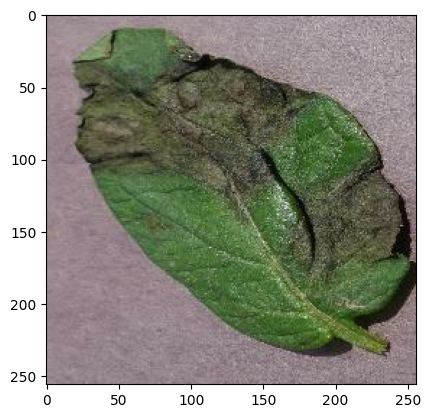

In [34]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    plt.imshow(first_image)
    print("first image's actual label: ", classes[first_label])
    batch_prediction = model.predict(images_batch)
    print("first image's predicted label" , classes[np.argmax(batch_prediction[0])])

In [35]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


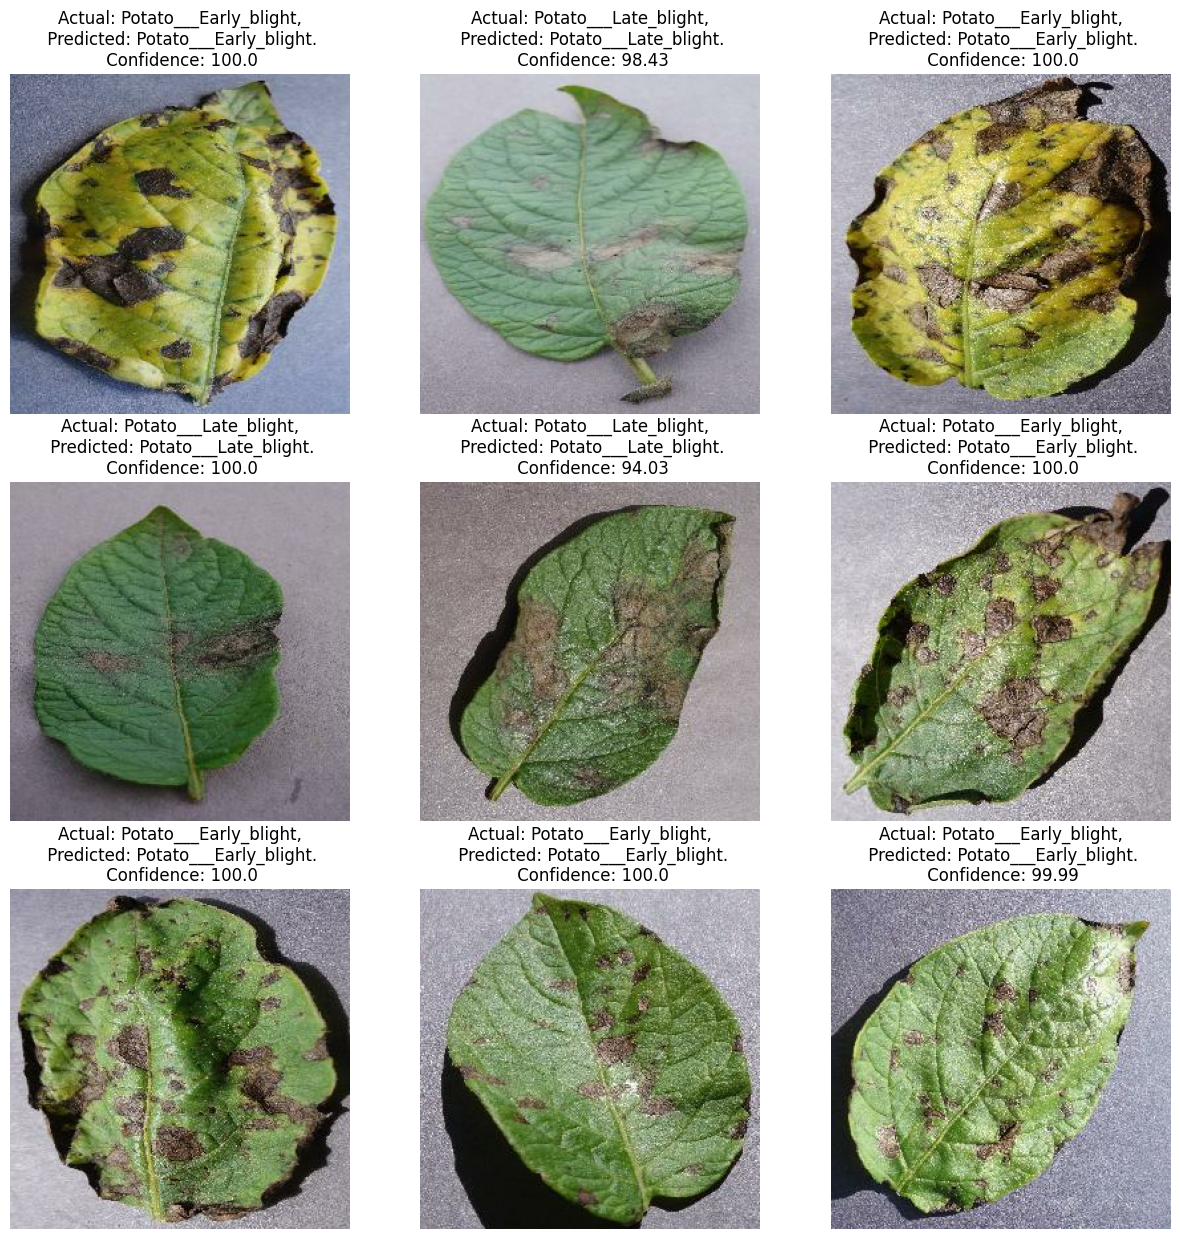

In [36]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        show = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = classes[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis("off")

In [ ]:
#model_saving
model.save('training.keras')